In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# ApI to fetch  the dataset from Kaggle
!kaggle datasets download -d milobele/sentiment140-dataset-1600000-tweets

Dataset URL: https://www.kaggle.com/datasets/milobele/sentiment140-dataset-1600000-tweets
License(s): unknown
 96% 78.0M/81.0M [00:01<00:00, 89.4MB/s]
100% 81.0M/81.0M [00:01<00:00, 83.3MB/s]


In [ ]:
# extracting the compressed dataset
from zipfile import ZipFile
import os
dataset = '/content/sentiment140-dataset-1600000-tweets.zip'

# Check if the dataset file exists
if os.path.exists(dataset):
    with ZipFile(dataset, 'r') as zip:
        zip.extractall()  # Extract all contents to the current directory
        print('The dataset is extracted')
else:
    print(f'The file {dataset} does not exist.')

The dataset is extracted


Importing Libraries

In [ ]:
# utilites
import pandas as pd
import numpy as np
import re
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#printing the stopwaords in English
stopwordlist=stopwords.words('english')
print(len(stopwordlist))
print(stopwordlist)


179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

Data Processing

In [ ]:
#load the data from csv file to pandas dataframe
df=pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='latin-1')

In [ ]:
df.shape

(1599999, 6)

In [ ]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
#naming the columns and reading again
column_names = ['target','ids','date','flag','user','text']
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',header=None,encoding='latin-1',names=column_names)

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Columns/ feature in data
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [ ]:
# Lenght of the dataset
print('length of data is',len(df))

length of data is 1600000


In [ ]:
# Shape of data
df.shape

(1600000, 6)

In [ ]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
# checking for null values
df.isnull().sum()

,0
target,0
ids,0
date,0
flag,0
user,0
text,0


In [ ]:
np.sum(df.isnull().any(axis=1))

0

In [ ]:
# Check unique target values
df['target'].unique()

array([0, 4])

In [ ]:
# Checking the number of target values
df['target'].nunique()

2

Data Visualization of Target Variables

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

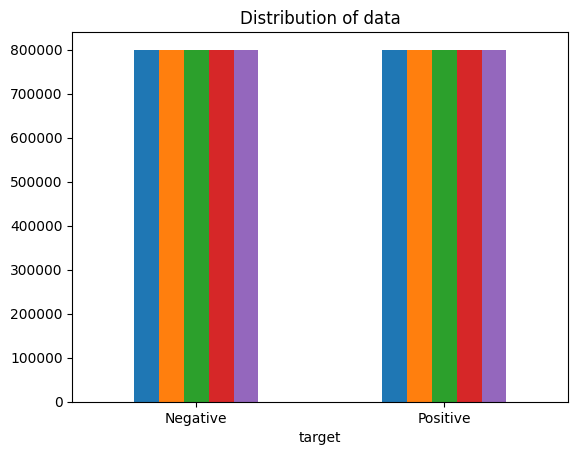

In [ ]:
# plotting the distribution for dataset.
ax= df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

The target variables of contains positive and negative vales are equal

Data Preprocessing

In the above-given problem statement, before training the model, we performed various pre-processing steps on the dataset that mainly dealt with removing stopwords, removing special characters like emojis, hashtags, etc. The text document is then converted into lowercase for better generalization.

Subsequently, the punctuations were cleaned and removed, thereby reducing the unnecessary noise from the dataset. After that, we also removed the repeating characters from the words along with removing the URLs as they do not have any significant importance.

At last, we then performed Stemming(reducing the words to their derived stems) and Lemmatization(reducing the derived words to their root form, known as lemma) for better results.


Selecting the Text and Target column for our further analysis

In [ ]:
data= df[['text','target']]

Replacing the values to easy understanding
(Assigning 1 to Positive sentiment 4)


In [ ]:
data['target']=data['target'].replace(4,1)

<ipython-input-22-784d662c4464>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target']=data['target'].replace(4,1)


In [ ]:
# Printing unique values of target variables
data['target'].unique()

array([0, 1])

In [ ]:
# Seprating positive and negative tweets
data_pos=data[data['target']==1]
data_neg=data[data['target']==0]

In [ ]:
# Taking one-fourth of the data so we can run it on our machine easily
data_pos=data_pos.iloc[:len(data_pos)]
data_neg=data_neg.iloc[:len(data_neg)]

In [ ]:
print(data_pos.shape)
print(data_neg.shape)

(800000, 2)
(800000, 2)


In [ ]:
# Combining positive and negative tweets
dataset= pd.concat([data_pos,data_neg])

In [ ]:
# Convert all text to lowercase
dataset['text']= dataset['text'].str.lower()
print('This is head of text data\n',dataset['text'].head())
print('\n')

print('This is tail of text data\n',dataset['text'].tail())

This is head of text data
 800000         i love @health4uandpets u guys r the best!! 
800001    im meeting up with one of my besties tonight! ...
800002    @darealsunisakim thanks for the twitter add, s...
800003    being sick can be really cheap when it hurts t...
800004      @lovesbrooklyn2 he has that effect on everyone 
Name: text, dtype: object


This is tail of text data
 799995    sick  spending my day laying in bed listening ...
799996                                      gmail is down? 
799997                        rest in peace farrah! so sad 
799998    @eric_urbane sounds like a rival is flagging y...
799999    has to resit exams over summer...  wishes he w...
Name: text, dtype: object


Removing the stopwordlist  from the tweets text columns

In [ ]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves','u','r']

In [ ]:
STOPWORDS = set(stopwordlist) # set of stop words
def clean_stopwordslist(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: clean_stopwordslist(text))
print('This is head of text data\n',dataset['text'].head())
print('\n')

print('This is tail of text data\n',dataset['text'].tail())

This is head of text data
 800000                    love @health4uandpets guys best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object


This is tail of text data
 799995    sick spending day laying bed listening @taylor...
799996                                          gmail down?
799997                               rest peace farrah! sad
799998    @eric_urbane sounds like rival flagging ads. n...
799999    resit exams over summer... wishes worked harde...
Name: text, dtype: object


In [ ]:
STOPWORDS = set(stopwords.words('english')) # set of stop words
def clean_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: clean_stopwords(text))
print('This is head of text data\n',dataset['text'].head())
print('\n')

print('This is tail of text data\n',dataset['text'].tail())

This is head of text data
 800000                    love @health4uandpets guys best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object


This is tail of text data
 799995    sick spending day laying bed listening @taylor...
799996                                          gmail down?
799997                               rest peace farrah! sad
799998    @eric_urbane sounds like rival flagging ads. m...
799999    resit exams summer... wishes worked harder fir...
Name: text, dtype: object


In [ ]:
dataset['text'][800001]

'im meeting one besties tonight! cant wait!! - girl talk!!'

In [ ]:
def cleaning_urls(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_urls(x))
dataset['text'].head()

,text
800000,love @health4uandpets guys best!!
800001,im meeting one besties tonight! cant wait!! - ...
800002,"@darealsunisakim thanks twitter add, sunisa! g..."
800003,sick really cheap hurts much eat real food plu...
800004,@lovesbrooklyn2 effect everyone


Removing punctuations

In [ ]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations

def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
print('This is head of text data\n',dataset['text'].head())
print('\n')

print('This is tail of text data\n',dataset['text'].tail())

This is head of text data
 800000                       love health4uandpets guys best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                       lovesbrooklyn2 effect everyone
Name: text, dtype: object


This is tail of text data
 799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads much...
799999    resit exams summer wishes worked harder first ...
Name: text, dtype: object


Removing repeating characters

In [ ]:
# def cleaning_repeating_char(text):
#     return re.sub(r'(.)1+', r'1', text)
# dataset['text']= dataset['text'].apply(lambda x: cleaning_repeating_char(x))

# print('This is head of text data\n',dataset['text'].head())
# print('\n')

# print('This is tail of text data\n',dataset['text'].tail())

Removing numerical values from the text columns


In [ ]:
def cleaning_numerical(data):
  return re.sub('[0-9]+','', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numerical(x))
print('This is head of text data\n',dataset['text'].head())
print('\n')

print('This is tail of text data\n',dataset['text'].tail())


This is head of text data
 800000                        love healthuandpets guys best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                        lovesbrooklyn effect everyone
Name: text, dtype: object


This is tail of text data
 799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads much...
799999    resit exams summer wishes worked harder first ...
Name: text, dtype: object


Getting tokenization of tweets test

In [ ]:
# from nltk.tokenize import RegexpTokenizer
# tokenizer = RegexpTokenizer(r'w+')
# dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
# print('This is head of text data\n',dataset['text'].head())
# print('\n')

# print('This is tail of text data\n',dataset['text'].tail())
# dataset.head()

# Stemming
 * Reducing the words to their derived stems

 * stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.


 eg.
 * Porter Stemmer:

Original: running, Stemmed: run

Original: runner, Stemmed: runner

Original: ran, Stemmed: ran


In [ ]:
from nltk.stem import PorterStemmer

port_stemmer = PorterStemmer()

def stemming_on_text(data):

    # Call the stem method of port_stemmer object
    text=[port_stemmer.stem(word) for word in data]
    return data

dataset['text'] = dataset['text'].apply(lambda x: stemming_on_text(x))
print('This is head of text data\n',dataset['text'].head())
print('\n')

print('This is tail of text data\n',dataset['text'].tail())


This is head of text data
 800000                        love healthuandpets guys best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                        lovesbrooklyn effect everyone
Name: text, dtype: object


This is tail of text data
 799995    sick spending day laying bed listening taylors...
799996                                           gmail down
799997                                rest peace farrah sad
799998    ericurbane sounds like rival flagging ads much...
799999    resit exams summer wishes worked harder first ...
Name: text, dtype: object


In [ ]:
dataset.head()

,text,target
800000,love healthuandpets guys best,1
800001,im meeting one besties tonight cant wait girl...,1
800002,darealsunisakim thanks twitter add sunisa got ...,1
800003,sick really cheap hurts much eat real food plu...,1
800004,lovesbrooklyn effect everyone,1


## Lemmatizer
lemmatization is a process that transforms words into their base or root form.

For example, the words "running," "ran," and "runs" would all be lemmatized to the base form "run."

In [ ]:
import nltk
!pip install nltk
nltk.download('wordnet') # downloads the 'wordnet' resource

lm= nltk.WordNetLemmatizer()

def lemmatizer_on_text(data):

    text=[lm.lemmatize(word) for word in data]
    return data

dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...


,text
800000,love healthuandpets guys best
800001,im meeting one besties tonight cant wait girl...
800002,darealsunisakim thanks twitter add sunisa got ...
800003,sick really cheap hurts much eat real food plu...
800004,lovesbrooklyn effect everyone


Seprating input features and label

In [ ]:
X=data.text
y=data.target

In [ ]:
print(len(X))
print(len(y))

1600000
1600000


Plot a cloud of words for Negative tweets

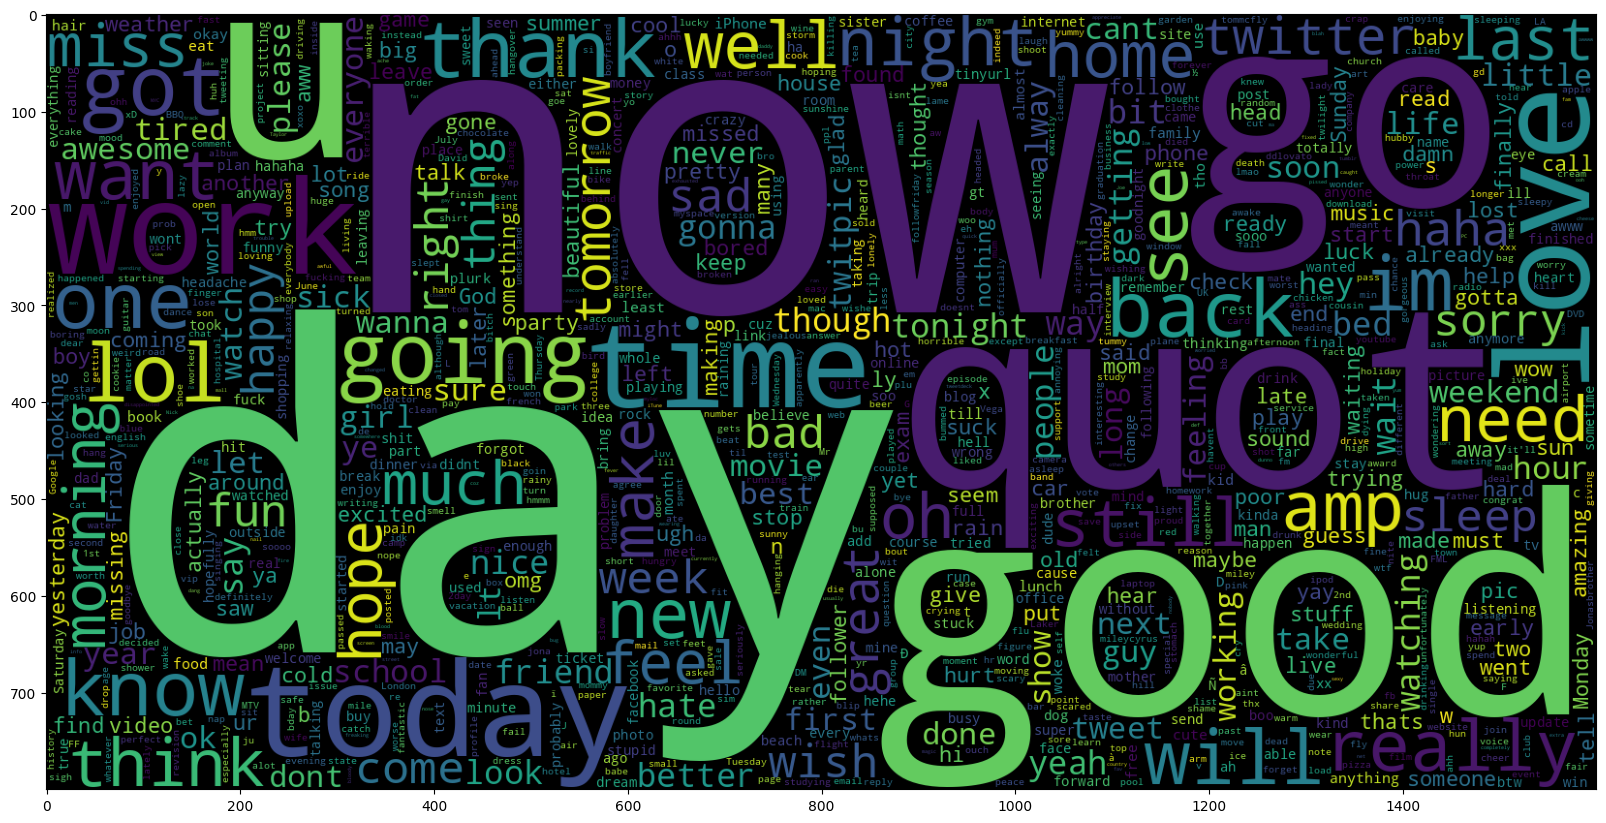

In [ ]:
!pip install wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

data_neg = data['text']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

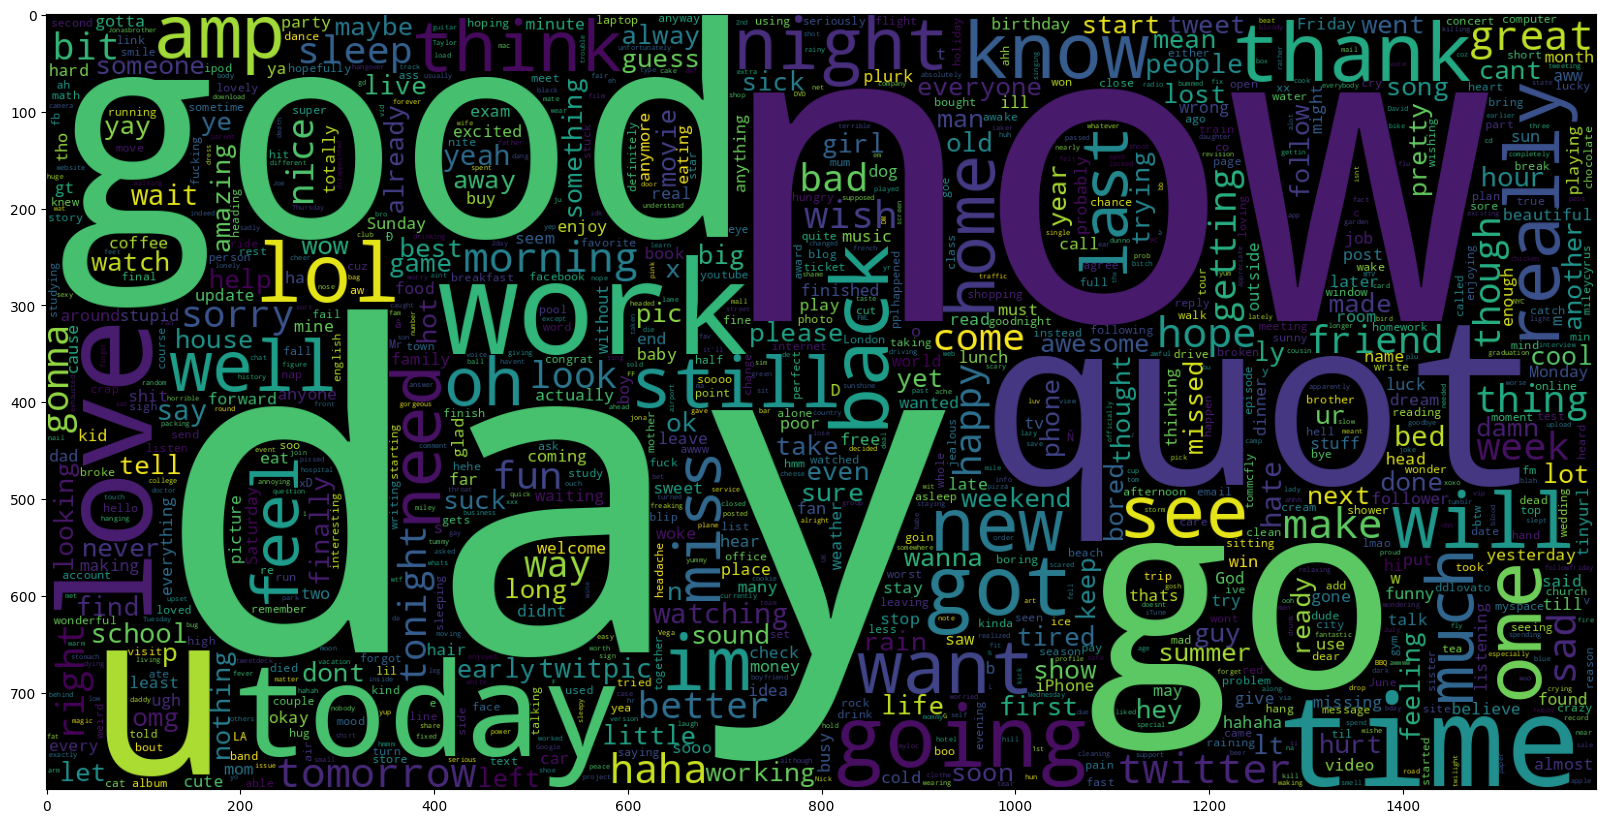

In [ ]:
# Assuming 'text' column contains the text data you want to visualize
data_pos = data['text']
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)


Splitting Our Data into Train and Test Subsets

In [ ]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state =42)

In [ ]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1120000
480000
1120000
480000


Transforming the Dataset Using TF- IDF Vectorizer

In [ ]:
#converting the textual data to numerical data
vectorizer= TfidfVectorizer()
X_train= vectorizer.fit_transform(X_train)
X_test= vectorizer.transform(X_test)

In [ ]:
print(X_train)

  (0, 406143)	0.18837001695731653
  (0, 440596)	0.1951303861588848
  (0, 235451)	0.11983982376723208
  (0, 50348)	0.1193423705448475
  (0, 333920)	0.23445848953540677
  (0, 304374)	0.20485935924392745
  (0, 355010)	0.09648205815042024
  (0, 313566)	0.1521626376869352
  (0, 512748)	0.12026623148223566
  (0, 118539)	0.26566575858675384
  (0, 340109)	0.07074942051982212
  (0, 457239)	0.18378743704774864
  (0, 99380)	0.10067022446547448
  (0, 488893)	0.17545230367989254
  (0, 201430)	0.2145499706179811
  (0, 520188)	0.31837913676731255
  (0, 229713)	0.07974693541956657
  (0, 380201)	0.1689068468056853
  (0, 208982)	0.26058367127032805
  (0, 471581)	0.4369096022969522
  (0, 234798)	0.16395910802365576
  (0, 147252)	0.36841582248659926
  (1, 253367)	0.27553894838443566
  (1, 42112)	0.2728120613981423
  (1, 235103)	0.09464334482888374
  :	:
  (1119998, 222693)	0.2304746111612065
  (1119998, 509124)	0.24669180387566617
  (1119998, 87499)	0.18946206616692834
  (1119998, 464148)	0.23129988464226

In [ ]:
print(X_test)

  (0, 531750)	0.2711284684055641
  (0, 360763)	0.3569742620291956
  (0, 219592)	0.3094720116021608
  (0, 112650)	0.6935524442506389
  (0, 41366)	0.47145605413192115
  (1, 491934)	0.26272642629141696
  (1, 397927)	0.5537642962993318
  (1, 353350)	0.1821674564234399
  (1, 340109)	0.12165514926170792
  (1, 327117)	0.5777500415031038
  (1, 210526)	0.15352844250975373
  (1, 183969)	0.13678612518709593
  (1, 122912)	0.25412731858906384
  (1, 57528)	0.3683445945541971
  (2, 517989)	0.1169550299777069
  (2, 514018)	0.24573130779568927
  (2, 480589)	0.1388282281703462
  (2, 479455)	0.45423643136881686
  (2, 439606)	0.2989217947550147
  (2, 365704)	0.12764144358248303
  (2, 364183)	0.15802787599390913
  (2, 348686)	0.17452087057365034
  (2, 289219)	0.12936177061497478
  (2, 280839)	0.24355922926085932
  (2, 274036)	0.1422062689008427
  :	:
  (479998, 433698)	0.1946345013120972
  (479998, 406340)	0.1874760039927674
  (479998, 398948)	0.16729738027613278
  (479998, 359104)	0.11973399928849832
  (4

## Function for Model Evaluation

After training the model , we apply the evaluation measures to check how the model is performing. Accordingly , we use the following evaluation parameters to check the performance of the models respectively

*  Accuracy Score
*  Confusion Matrix with Plot
*  ROC- AUC Curve


In [ ]:
import zipfile # import zipfile module
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import builtins # import the builtins module


def model_Evaluate(model):
  # Predict values for Test dataset
  y_pred = model.predict(X_test)

  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))

  # Print the accuracy score
  accuracy_test = accuracy_score(y_test, y_pred)  # Calculate accuracy
  print(f'Accuracy: {accuracy_test:.2f}')  # Print accuracy score

  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

  # use the built-in zip function. The user probably overwrote the zip function with a ZipFile object
  labels = [f'{v1}\n{v2}' for v1, v2 in builtins.zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)



## Model Building

In the problem statement, we have used three different models respectively:
  * Bernoulli Naive Bayes Classifier
  * SVM (Support Vector Machine)
  * Logistic Regression

The idea behind choosing these models is that we want to try all the classifiers on the dataset ranging from simple ones to complex models, and then try to find out the one which  gives the best performance among them






## Model -1 Bernoulli Naive Bayes Classifier

              precision    recall  f1-score   support

           0       0.77      0.81      0.79    239361
           1       0.80      0.76      0.78    240639

    accuracy                           0.78    480000
   macro avg       0.78      0.78      0.78    480000
weighted avg       0.78      0.78      0.78    480000

Accuracy: 0.78


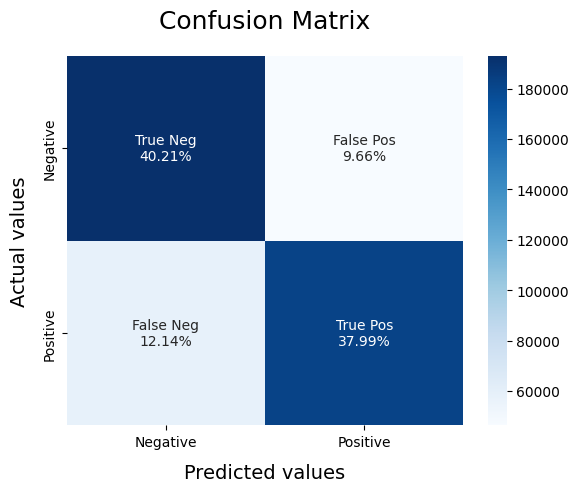

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)


## Plot the ROC-AUC Curve for model-1

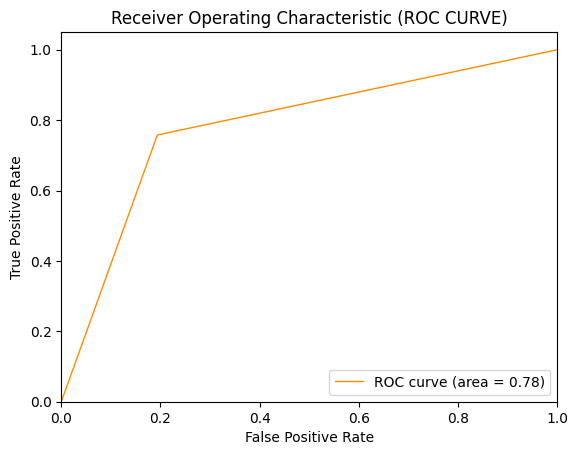

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC CURVE)')
plt.legend(loc="lower right")
plt.show()


## Model-2 Suppot Vector Mechine

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.80      0.79      0.79    239361
           1       0.79      0.80      0.80    240639

    accuracy                           0.80    480000
   macro avg       0.80      0.80      0.80    480000
weighted avg       0.80      0.80      0.80    480000

Accuracy: 0.80


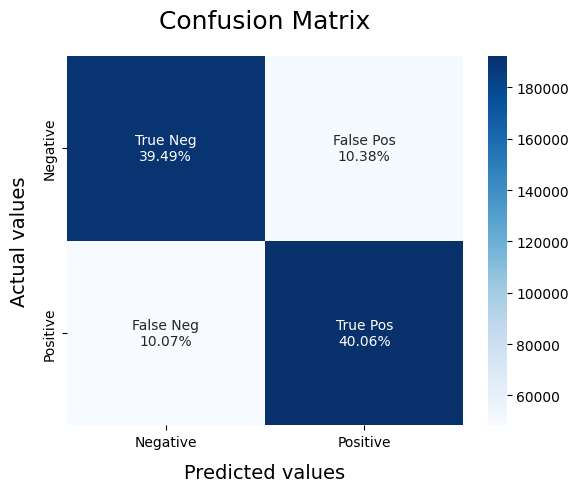

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)


## Plot the ROC-AUC Curve for model-2

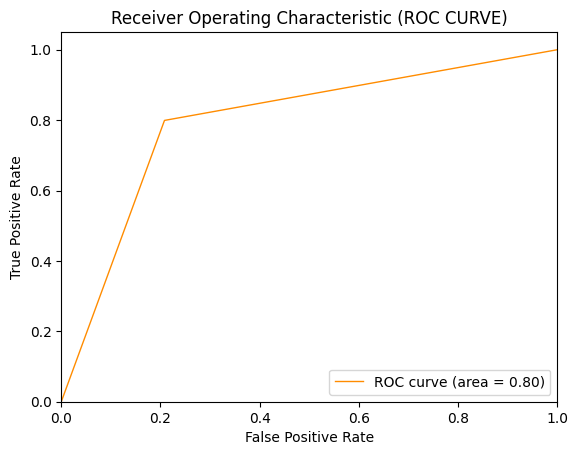

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC CURVE)')
plt.legend(loc="lower right")
plt.show()

## Model-3 Logistic Regression

              precision    recall  f1-score   support

           0       0.81      0.79      0.80    239361
           1       0.80      0.81      0.80    240639

    accuracy                           0.80    480000
   macro avg       0.80      0.80      0.80    480000
weighted avg       0.80      0.80      0.80    480000

Accuracy: 0.80


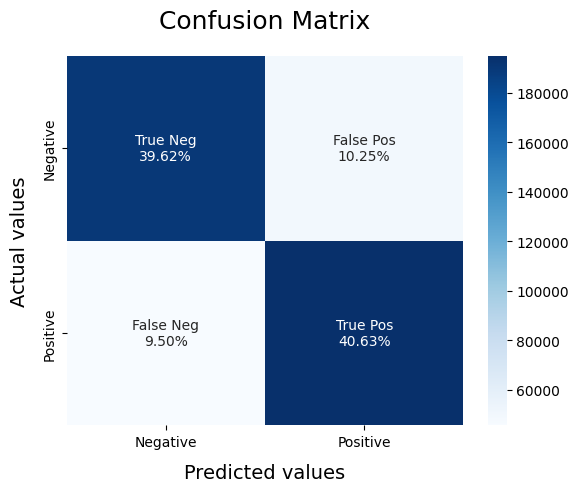

In [ ]:
LRmodel = LogisticRegression(C = 2,max_iter= 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

Plot the ROC-AUC Curve for model-3

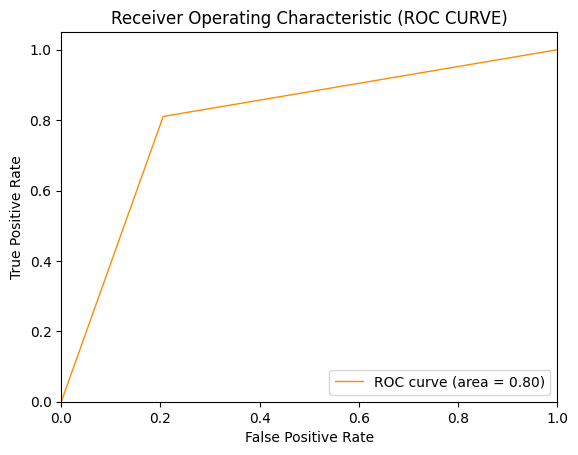

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC CURVE)')
plt.legend(loc="lower right")
plt.show()

## Model Evaluation
upon evaluating the models , we can conclude the following details i.e.

#### Accuracy:
  As far as the accuracy of the model is connected, Logistic REgression  and Suppot Vector Mechine(SVM) performs better than Bernoulli Naive Bayes.

 #### F1- Score
  The F1 Scores for class 0 and class 1 are:
  *  For class 0: Logistic Regression (accuracy=80 ) == SVM > Bernoulli Naive Bayes : 79

  * FOr class 1:Logistic Regression  and SVM  is  (accuracy=80 ) > Bernoulli Naive Bayes : 78

#### AUC Score :
   Logistic Regression == SVM (accuracy= 80) > Bernoulli Naive Bayes (accuracy=78)

 We, therefore, conclude that the Logistic Regression is the best model for the above-given dataset.  
      
  In our problem statement, Logistic Regression follows the principle of Occam’s Razor, which defines that for a particular problem statement, if the data has no assumption, then the simplest model works the best. Since our dataset does not have any assumptions and Logistic Regression is a simple model. Therefore, the concept holds true for the above-mentioned dataset.


In [ ]:
import pickle

# Save the trained model
filename = 'trained_model_Logistic_regression.sav'
with open(filename, 'wb') as file:
    pickle.dump(BNBmodel, file)  # Ensure you use your actual model here

# Using the saved model for further predictions
with open('trained_model_Logistic_regression.sav', 'rb') as file:
    loaded_model = pickle.load(file)

# Select the 301st row of the test dataset
X_new = X_test[300, :].reshape(1, -1)  # Reshape for a single sample

# Access the actual label of the 301st sample
index_300 = y_test.index[300]  # Get the actual index value at position 300
actual_label = y_test.loc[index_300]  # Use .loc to access by index value
print(f'Actual Label: {actual_label}')  # Print actual label

# Make the prediction using the loaded model
prediction = loaded_model.predict(X_new)
print(f'Predicted Label: {prediction[0]}')

# Interpret the prediction
if prediction[0] == 0:
    print('The news is a Negative Tweet')
else:
    print('The news is a Positive Tweet')


Actual Label: 1
Predicted Label: 1
The news is a Positive Tweet
